# Analyzing spectrogram of different instruments to discriminate between them

Musical instruments have different **Timbre** that measures the quality of their sound, so same notes (frequency), can sound different depending on the instruments.


In [2]:
import matplotlib.pyplot as plt
import librosa
import numpy as np
import seaborn as sns
from scipy import signal

# For synthesis, we'll use mir_eval's sonify module
import mir_eval.sonify

# For audio playback, we'll use IPython.display's Audio widget
from IPython.display import Audio



# Getting audio files

In [3]:

# Samples are from: Guitar, Saxophone, Violin, Percussion (different ones) in mp3 format
path_to_samples = 'all_samples/'

#guitar = librosa.load('all-samples/guitar/guitar_A3_very-long_forte_normal.mp3', sr=44100)[0]
# Strings

guitar_harmonic_natural = librosa.load('all-samples/guitar/guitar_A4_very-long_forte_harmonics.mp3', sr=44100)[0]
guitar_simple = librosa.load('all-samples/guitar/guitar_A4_very-long_forte_normal.mp3', sr=44100)[0]

guitar = librosa.load('all-samples/guitar/guitar_A3_very-long_piano_normal.mp3', sr=44100)[0]
banjo = librosa.load('all-samples/banjo/banjo_A3_very-long_forte_normal.mp3', sr=22050)[0]
violin = librosa.load('all-samples/violin/violin_A3_15_forte_arco-normal.mp3', sr= 44100)[0]
violin_glissato = librosa.load('all-samples/violin/violin_As4_phrase_mezzo-forte_arco-glissando.mp3', sr = 44100)[0] 

# Woodwinds
saxophone = librosa.load('all-samples/saxophone/saxophone_A3_15_forte_normal.mp3', sr = 44100)[0]
clarinet = librosa.load('Woodwind/clarinet/clarinet_A3_15_forte_normal.mp3', sr = 44100)[0]

#Brass
trumpet = librosa.load('Brass/trumpet/trumpet_A3_15_forte_normal.mp3', sr = 44100)[0]

#percussion = librosa.load('all-samples/percussion/cowbell/cowbell__025_mezzo-forte_damped.mp3', sr = 44100)[0]

# Using pyin to get the fundamental frequency

#f0, the sequence of fundamental frequency estimates

#voicing, the sequence of indicator variables for whether a fundamental was detected or not at each time step

#voicing_probability, the sequence of probabilities that each time step contains a fundamental frequency
f0_guitar, voicing_guitar, voiced_prob_guitar = librosa.pyin(guitar, fmin = 70, fmax = 900)
f0_banjo, voicing_banjo, voiced_prob_banjo = librosa.pyin(guitar, fmin = 55, fmax = 900)
f0_saxophone , voicing_saxophone, voiced_prob_saxohpone = librosa.pyin(saxophone, fmin = 10, fmax = 900)
f0_violin, voicing_violin, voiced_prob_violin = librosa.pyin(violin, fmin = 10, fmax = 900)
f0_trumpet, voicing_trumpet, voiced_prob_trumpet = librosa.pyin(trumpet, fmin = 10, fmax = 900)
f0_clarinet, voicing_clarinet, voiced_prob_clarinet = librosa.pyin(clarinet, fmin = 10, fmax = 900)

f0_violin_glissato, voicing_violin_glissato, voiced_prob_violin_glissato = librosa.pyin(violin_glissato, fmin = 10, fmax = 900)

f0_guitar_harmonic_natural, voicing_guitar_harmonic_natural, voiced_prob_guitar_harmonic_natural = librosa.pyin(guitar_harmonic_natural, fmin = 10, fmax = 900)
f0_guitar_simple, voicing_guitar_simple, voiced_prob_guitar_simple = librosa.pyin(guitar_simple, fmin = 10, fmax = 900)


# pure siine wave at 110 Hz



In [4]:
def mean_f0(f0, instrument):
    
    f0 = f0[0:44100]
    # get rid of nan values
    f0_instrument = f0[~np.isnan(f0)]

    print("Fundamental frequency of", instrument, "is", np.mean(f0_instrument))
    
    return np.mean(f0_instrument)


In [5]:

Audio(guitar, rate=44100)

In [6]:
Audio(saxophone, rate=44100)

In [7]:
Audio(banjo, rate=44100)

In [8]:
Audio(violin, rate=44100)

In [9]:
Audio(clarinet, rate=44100)

In [10]:
Audio(trumpet, rate=44100)

# Wavelet and STFT Formula

We saw at lesson Wavelets Transform that is a useful insturment to analyze the time-frequency domain of signals, basically what we do with our Wavelet (a signal finite in time) is to convolve it with our original signal, and then scale it and shift it to get a new signal, that is the Wavelet Transform of our original signal.

In [11]:

def plot_spectrogram(audio, f0, instrument, sr=44100):
    ''' 
    Using audio and given fundamental plots the spectrogram
    returns 
    '''

    # stft has 
    S = np.abs(librosa.stft(audio, n_fft=2048, hop_length=512))
    times = librosa.times_like(S, sr=sr)

    # Plot the spectrogram
    sns.set_style('white')
    
    fig, ax = plt.subplots()

    img = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                             y_axis = 'log', x_axis = 'time', ax = ax)

    ax.plot(times, f0, label='f0', color='green', linewidth=1.5)

    #Add legend for f0 frequency
    f0_frequency = mean_f0(f0, instrument)
    #Trim to 2 decimal places
    ax.axhline(f0_frequency, color='red', linestyle='dotted', linewidth=1.5, label='f0 frequency:' + str(round(f0_frequency,2)) + 'Hz')
   
    fig.colorbar(img, ax=ax) 
    
    ax.set_title('Spectrogram of ' + instrument)
    
    ax.legend(loc='upper right')
    
    return S

In [21]:
def plot_spectrogram_by_rows(audio_list, f0_list, instrument_list, sr=44100, ax = None):
    ''' 
    Using audio and given fundamental plots the spectrogram
    returns 
    Plot the spectrogram in a subplot in a single row
    '''
    
    index = 0
    # Since we don't know S what size it will be, we just know that each S[i] will have a different size
    S = np.empty(len(audio_list), dtype=object)
    #time is a list of list for eahc of the instruments
    times = np.empty(len(audio_list), dtype=object)
    img = np.empty(len(audio_list), dtype=object)


    for audio in audio_list:
        
        S[index] = np.abs(librosa.stft(audio, n_fft=2048, hop_length=512))
        times[index] = librosa.times_like(S, sr=sr)
        index += 1        

    # Plot the spectrogram
    sns.set_style('white')
    # Plot the spectrogram in a subplot of each instrument, we've 5 instruments
    
    fig, ax = plt.subplots(nrows=1, ncols=len(audio_list), figsize=(20, 4))

    
    for i in range(0, len(audio_list)):

        
        img[i] = librosa.display.specshow(librosa.amplitude_to_db(S[i], ref=np.max),
                                 y_axis = 'log', x_axis = 'time', ax = ax[i])
        
        
        #Add legend for f0 frequency, but 
        f0_frequency = mean_f0(f0_list[i], instrument_list[i])
        #Trim to 2 decimal places
        ax[i].axhline(f0_frequency, color='blue', linestyle='dotted', linewidth=1.5, label='f0 frequency:' + str(round(f0_frequency,2)) + 'Hz')
        ax[i].set_title('Spectrogram of ' + instrument_list[i])
        ax[i].legend(loc='upper right', fontsize='small')

        # add spacing between subplots
        fig.subplots_adjust(wspace=0.5)
    # one colorbar for all the subplots
    fig.colorbar(img[0], ax=ax.ravel().tolist())
        
    return S
  
   

In [13]:
def plot_harmonics(f0, S, instrument):
    '''
    We're doing fourier decomposition to get the harmocis
    '''

    # Let's use the first n harmonics
    harmonics = np.arange(1, 50)

    # And standard Fourier transform frequencies
    frequencies = librosa.fft_frequencies(sr=44100, n_fft=2048)

    harmonic_energy = librosa.f0_harmonics(S, f0=f0, harmonics=harmonics, freqs=frequencies)

    fig, ax = plt.subplots(nrows=2, sharex=True)
    
    # set title of plot to instrument, using subplots
    fig.suptitle('Harmonic energy of ' + instrument, fontsize=16)
 
    
    librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                             y_axis='log', x_axis='time', ax=ax[0])
    librosa.display.specshow(librosa.amplitude_to_db(harmonic_energy, ref=np.max),
                             x_axis='time', ax=ax[1])
    ax[0].label_outer()
    ax[1].set(ylabel='Harmonics')

In [54]:
def plot_harmonics_only(f0, S, instrument):
    '''
    We're doing fourier decomposition to get the harmocis
    '''

    # Let's use the first n harmonics
    harmonics = np.arange(1, 30)

    # And standard Fourier transform frequencies
    frequencies = librosa.fft_frequencies(sr=44100, n_fft=2048)

    harmonic_energy = librosa.f0_harmonics(S, f0=f0, harmonics=harmonics, freqs=frequencies)

    fig, ax = plt.subplots(nrows=1, sharex=True)
    
    # set title of plot to instrument, using subplots
    fig.suptitle('Harmonic energy of ' + instrument, fontsize=16)
 
    
    #librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
    #                         y_axis='log', x_axis='time', ax=ax[0])
    librosa.display.specshow(librosa.amplitude_to_db(harmonic_energy, ref=np.max),
                             x_axis='time', ax=ax)
    #put numbers on y axis for harmonics
    ax.set_yticks(harmonics)
    ax.set_yticklabels(harmonics)
    
    #ax[0].label_outer()
    ax.set(ylabel='Harmonics')

In [41]:
def plot_harmonics_by_row(f0_list, S, instrument_list):
    '''
    We're doing fourier decomposition to get the harmocis
    S is an array of signals, instrument_list is an array of instruments
    f0_list is an array of f0 values
    '''

    # Let's use the first n harmonics
    harmonics = np.arange(0, 5)

    # And standard Fourier transform frequencies
    frequencies = librosa.fft_frequencies(sr=44100, n_fft=2048)

    S_array = np.empty(len(S), dtype=object)
    harmonic_energy_array = np.empty(len(S), dtype=object)

    for i in range(0, len(S)):
        harmonic_energy_array[i] = librosa.f0_harmonics(S[i], f0=f0_list[i], harmonics=harmonics, freqs=frequencies)
        S_array[i] = S[i]

    fig, ax = plt.subplots(nrows=1, ncols=len(S), figsize=(10, 5), sharex=True)
    
    
    for i in range(0, len(S)):
        #librosa.display.specshow(librosa.amplitude_to_db(S_array[i], ref=np.max),
        #                         y_axis='log', x_axis='time', ax=ax[0][i])

        librosa.display.specshow(librosa.amplitude_to_db(harmonic_energy_array[i], ref=np.max),
                                 x_axis='time', ax=ax[i])
        #ax[0][i].label_outer()
        ax[i].set(ylabel='Harmonics')
        #ax[0][i].set_title(instrument_list[i])



Fundamental frequency of guitar is 111.93251591508631
Fundamental frequency of saxophone is 106.93509298861399
Fundamental frequency of violin is 109.9778468925591
Fundamental frequency of clarinet is 109.87933824010213
Fundamental frequency of trumpet is 119.05623519735859


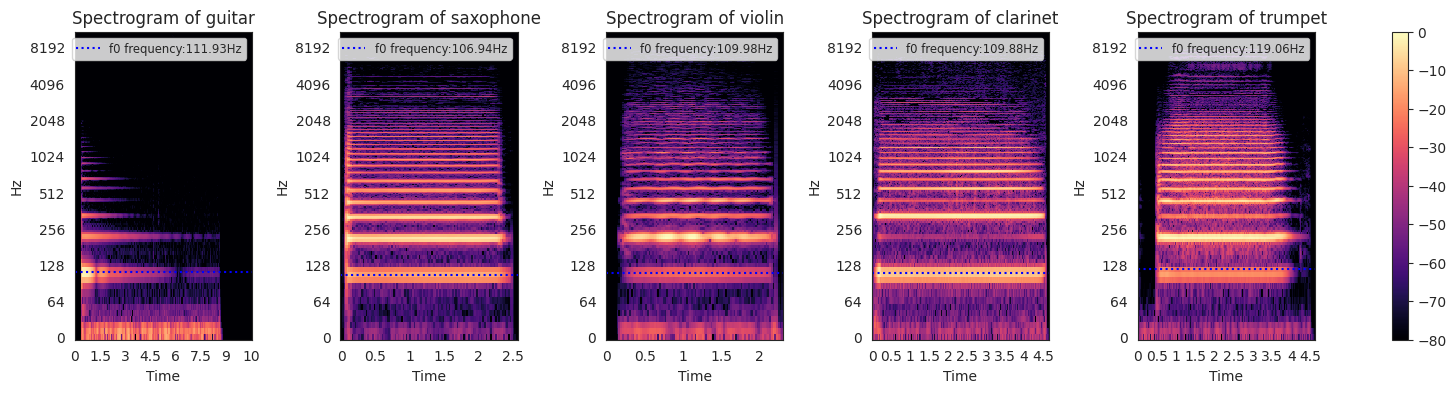

In [22]:
signals = plot_spectrogram_by_rows([guitar, saxophone, violin, clarinet, trumpet],
                     [f0_guitar, f0_saxophone, f0_violin, f0_clarinet, f0_trumpet],
                     ['guitar', 'saxophone', 'violin', 'clarinet', 'trumpet'])

Fundamental frequency of guitar is 111.93251591508631
Fundamental frequency of violin is 109.9778468925591
Fundamental frequency of saxophone is 106.93509298861399
Fundamental frequency of trumpet is 119.05623519735859
Fundamental frequency of clarinet is 109.87933824010213
(1025, 455) (455,)


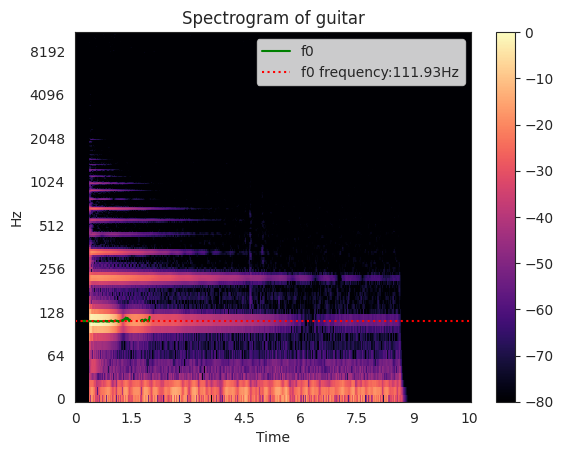

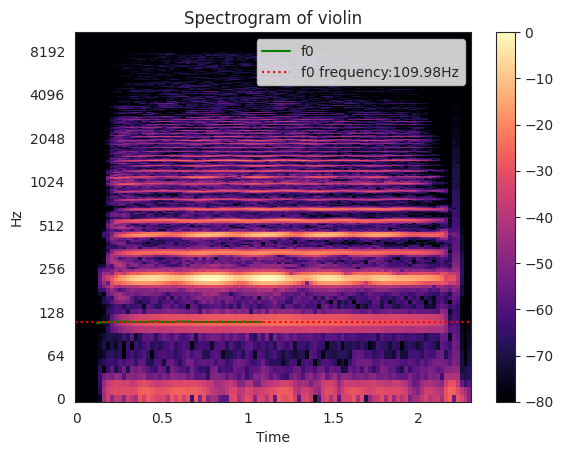

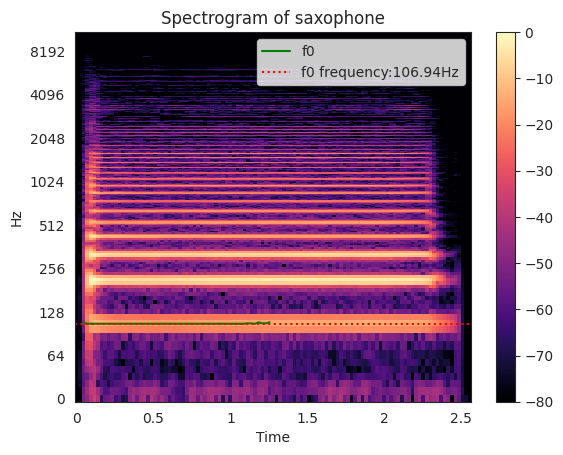

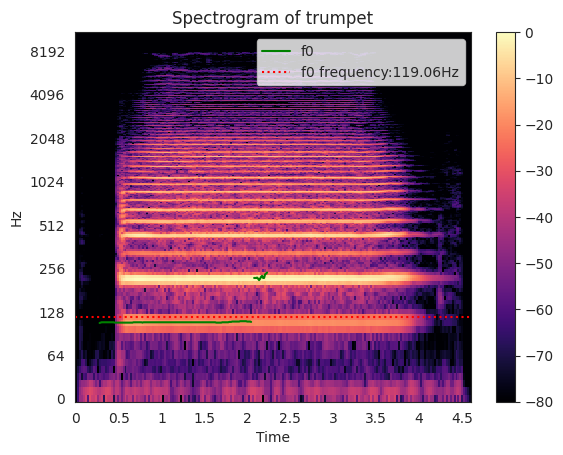

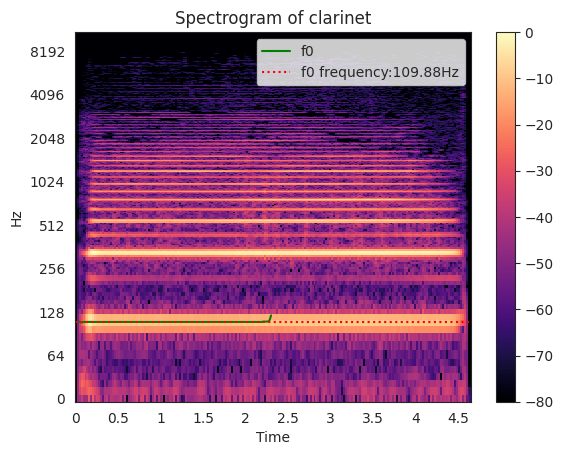

In [20]:

signal_guitar = plot_spectrogram(guitar,f0_guitar, instrument='guitar')
signal_violin = plot_spectrogram(violin, f0_violin, instrument='violin')
signal_saxophone = plot_spectrogram(saxophone, f0_saxophone, instrument='saxophone')
signal_trumpet = plot_spectrogram(trumpet, f0_trumpet, instrument='trumpet')
signal_clarinet = plot_spectrogram(clarinet, f0_clarinet, instrument='clarinet')


print(signal_guitar.shape, f0_guitar.shape)

(1025, 455) (455,)


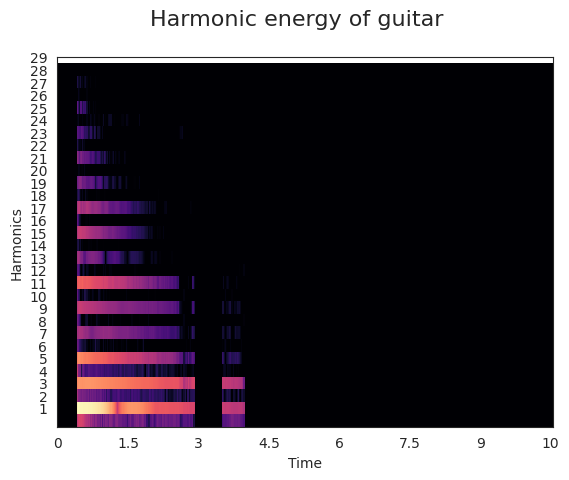

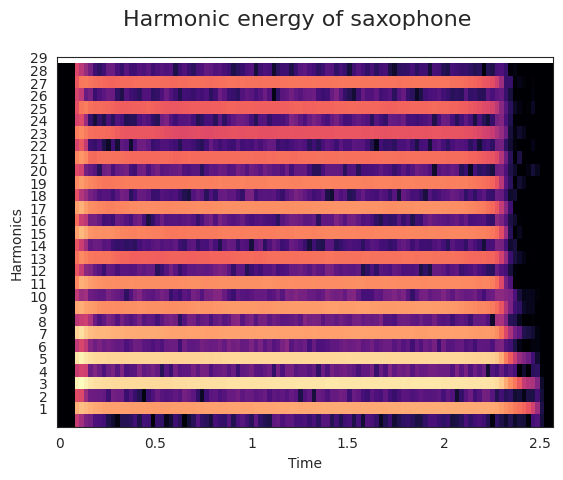

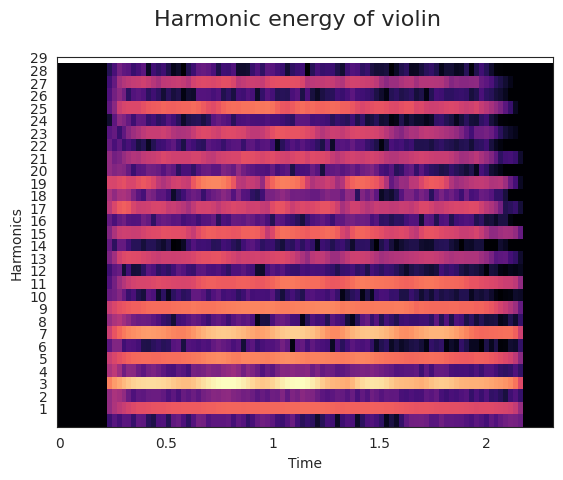

In [55]:
signal_guitar, signal_saxophone, signal_violin, signal_clarinet, signal_trumpet = signals

print(signal_guitar.shape, f0_guitar.shape)

plot_harmonics_only(f0=f0_guitar,S=signal_guitar, instrument='guitar')
plot_harmonics_only(f0=f0_saxophone, S = signal_saxophone, instrument='saxophone')
plot_harmonics_only(f0=f0_violin, S = signal_violin, instrument='violin')
#plot_harmonics(f0=f0_clarinet, S = signal_clarinet, instrument='clarinet')
#plot_harmonics(f0=f0_trumpet, S = signal_trumpet, instrument='trumpet')

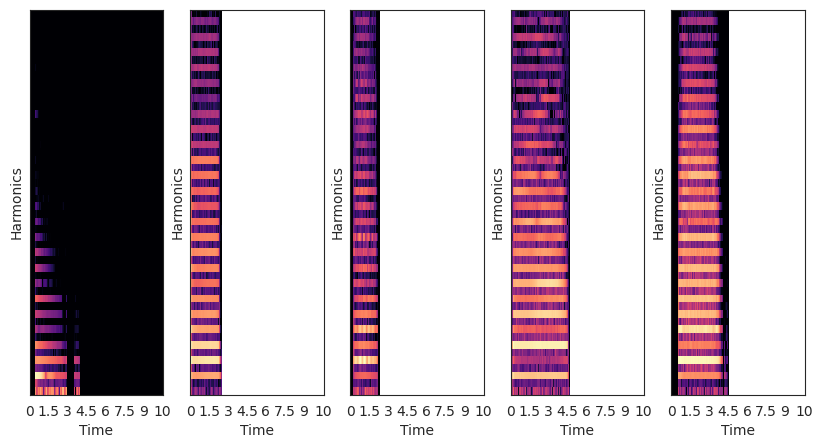

In [40]:
plot_harmonics_by_row(f0_list=[f0_guitar, f0_saxophone, f0_violin, f0_clarinet, f0_trumpet], 
                      S = [signal_guitar, signal_saxophone, signal_violin, signal_clarinet, signal_trumpet],
                        instrument_list=['guitar', 'saxophone', 'violin', 'clarinet', 'trumpet'])

In [ ]:
signal_violin_glissato = plot_spectrogram(violin_glissato, f0_violin_glissato, instrument='violin_glissato')
plot_harmonics(f0=f0_violin_glissato, S = signal_violin_glissato, instrument='violin_glissato')


# Detect notes, giving f0 and voicing
# we want to know what note is A,Ab,B,Bb,C,C#,D,Db,E,Eb,F,F#,G,Gb
#get rid of nans 
#f0_violin_glissato = f0_violin_glissato[~np.isnan(f0_violin_glissato)]


#take withot nans
f0_violin_glissato_no_nans = f0_violin_glissato[~np.isnan(f0_violin_glissato)]

f0_violin_glissato_max_freq = max(f0_violin_glissato_no_nans)
f0_violin_glissato_min_freq = min(f0_violin_glissato_no_nans)



f0_violin_glissato_mean = mean_f0(f0_violin_glissato, instrument='violin_glissato')

print("Starting note (low) is ", librosa.hz_to_note(f0_violin_glissato_min_freq))
print("Ending note (high) is ", librosa.hz_to_note(f0_violin_glissato_max_freq))

print("Middle note is: ",librosa.hz_to_note(f0_violin_glissato_mean))


# Other instruments
print("Guitar: ", librosa.hz_to_note(mean_f0(f0_guitar, instrument='guitar')))
print("Saxophone: ", librosa.hz_to_note(mean_f0(f0_saxophone, instrument='saxophone')))
print("Violin: ", librosa.hz_to_note(mean_f0(f0_violin, instrument='violin')))


In [ ]:
signal_guitar_harmonic_natural = plot_spectrogram(guitar_harmonic_natural, f0_guitar_harmonic_natural, instrument='guitar_harmonic_natural')

signal_guitar_simple = plot_spectrogram(guitar_simple, f0_guitar_simple, instrument='guitar_simple')

In [ ]:
plot_harmonics(f0=f0_guitar_simple, S = signal_guitar_simple, instrument='guitar_simple')
plot_harmonics(f0=f0_guitar_harmonic_natural, S = signal_guitar_harmonic_natural, instrument='guitar_harmonic_natural')

# Enanching the analysis with 3D plot of the spectrogram

A visual representation in 3D space in real time gives us a better understanding of the spectrogram of different instruments.

See the Obsidian doc


# Pleasurable discoveries

During the research for the assignment i found another useful tool related to timbre analysis and syntesis, for example google deplayed https://sites.research.google/tonetransfer, a tool that allows you to transfer the timbre of one instrument to another.